# Train, Validation, and Test

This notebook explores various methods for setting up training, validation, and testing splits for cross validation.

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

## Reading in Files Using A For Loop

Here's an example of code that reads in image data using a for loop. There are many ways to store and read in data, but we will use this one as a reference. 

For loops are sometimes not the most efficient way to read in data, but they can work. As datasets get larger, the individual file IO operations to read all the data can be cumbersome for testing. There are other methods, such as TFRecords, that make large dataset reading much easier.

In [1]:
#create function that gets the data from the folders
def get_data(data_dir):
    data = [] #make empty array
    for label in labels: #for each folder/label,
        if not label.startswith('.'): #for mac users who have issues with .DS_store files
            path = os.path.join(data_dir, label) #create the path for the folder
            class_num = labels.index(label) #index this label 
            for img in os.listdir(path): #for each image in the folder,
                if not img.startswith('.'): #for mac users who have issues with .DS_store files
                    img_arr = cv2.imread(os.path.join(path, img)) #retrieve the image array
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num]) #append the image array and label index to the data
                    
    return np.array(data, dtype=object) #return the images and label index array

### Data Is Not Split: Splitting Using Bash

You could manually split your dataset into folders, using bash scripting for instance. This might not be too hard, but for large datasets this can be computationally time consuming- it just depends. We will not show an example of how to do this here, but if you have data that is already organized into labeled/categorized folders, then making 3 folders (train, valid and test) and doling out the ratio could be a way forward.

This approach can be useful if you already know what ratio works best, and its a relatively smaller dataset. However, if you have a large dataset who you are just now encountering, a more flexible, code driven approach might be better; see the "Splitting Up Data With Code" section below.

### Data Is Already Split

Sometimes, our data comes split: some kind data scientist already went through the trouble of making train, valid, and/or test splits. In this case, it's as simple as importing the data into our Python script. Importing might be as simple as using pandas to read 3 separate .csv files: train.csv, valid.csv, test.csv. Other times, we might be importing images from a directory that we downloaded. Let's take a look at an example of importing images from a directory we downloaded.

The images here are part of a larger dataset of tomato leaves, some with diseases, and some healthy. It comes a project called Plantvillage, which captured numerous species of plants and tagged them with diseases from in the field or in the wild. These images have had data augmentation applied to them. We just took a few here to showcase an instance in which the data is split, but you can find more about the Plantvillage dataset here: https://paperswithcode.com/dataset/plantvillage. Specifically, we used images that had augmentation applied to them from this kaggle page: https://www.kaggle.com/datasets/ashishmotwani/tomato

The code below imports all the images from each train, valid and test directory using a for loop. You will notice that there are 4 labels, and 1 image per label, for a total of 12 images, meaning each train, valid and test has 4 images each.

After importing the data, it "unpacks" the numpy arrays and separates the data (x) from the labels (y), hence the train_x, train_y, valid_x, etc. 

In [3]:
#load the data
train_folder = 'images/train'
valid_folder = 'images/valid'
test_folder = 'images/test'

#declare labels and image size
labels = os.listdir(train_folder) #this gets the labels, or categories, that the data was already sorted in. These images were presorted into folders, and this gets all the folder names as labels.
img_size = 255 #image size
num_labels = len(labels) #the number of labels

#retrieve the data from the folders, store as train valid and test
train = get_data(train_folder)
valid = get_data(valid_folder)
test = get_data(test_folder)

#unpacking: organizing the data into train test splits, with x being data, y being label, etc
train_x = []
train_y = []
for features, label in train:
    train_x.append(features)
    train_y.append(label)
train_x = np.array(train_x).reshape(-1, img_size, img_size, 3)
train_y = np.array(train_y)

valid_x = []
valid_y = []
for features, label in valid:
    valid_x.append(features)
    valid_y.append(label)
valid_x = np.array(valid_x).reshape(-1, img_size, img_size, 3)
valid_y = np.array(valid_y)

test_x = []
test_y = []
for features, label in test:
    test_x.append(features)
    test_y.append(label)
test_x = np.array(train_x).reshape(-1, img_size, img_size, 3)
test_y = np.array(train_y)

##go on to do preprocessing and model training, etc

Let's verify that the shape of the data is right. We should have 4 images, and 2 dimensions (x, y) each.

In [4]:
train.shape

(4, 2)

Just out of curiousity, let's make sure these images look like we think they will.

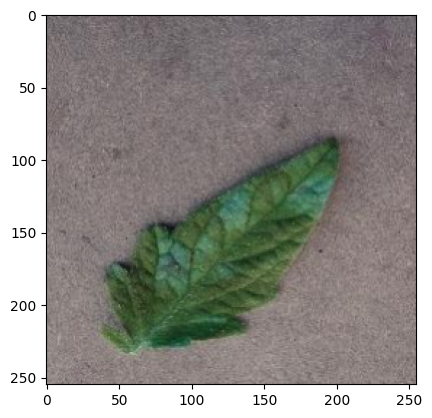

In [5]:
imgplot = plt.imshow(train_x[0])

Now the data has been read in, we have it separated into train, valid and test, and from here we can move on to preprocessing.

### Splitting Up Data With Code

Sometimes we get data that is not split up, but has labels, in which case we have to split it up ourselves. This can be somewhat easier to work with, because then *we* get to decide what the split ratios should be, and/or automatically try various combinations for split ratios.

The rule of thumb with split ratios is that 75-95% training data is somewhere in the ballpark of the best start for most datasets, but the biggest challenge when we start is that we just don't know what will be right. Instead of trying one, why not try a few combinations of split ratios?

Below we implement a for loop that tries out a few different combinations of split ratios, and automatically creates our train/valid/test splits for us.

In [6]:
data_folder = 'unsorted_images'
#declare labels and image size
labels = os.listdir(data_folder) #this gets the labels, or categories, that the data was already sorted in. These images were presorted into folders, and this gets all the folder names as labels.
img_size = 255 #image size
num_labels = len(labels) #the number of labels

all_data = get_data(data_folder)
np.random.shuffle(all_data) #shuffling the data

train_split_ratios = [50,70,90] #declare your split ratios. You can even use just a single value, like 90, if you only want to try 90/5/5, for instance.

for train_ratio in train_split_ratios:
    print("Now creating data where the training split size is: ", train_ratio,"%", sep="")
    leftover= 100 - train_ratio #calculate the leftover percentage, and divide by 2 to split evenly between test and valid
    
    total_images = all_data.shape[0] #getting the total number of images in our dataset
    
    valid_ratio = test_ratio = (leftover / 2) #divide the remaining data equally between validation and testing splits

    train_data_index = int(np.floor(total_images * (train_ratio/100)))
    valid_data_index = int(np.floor(total_images * (valid_ratio/100))) + train_data_index
    
    train = all_data[:train_data_index]
    valid = all_data[train_data_index+1:valid_data_index]
    test = all_data[valid_data_index+1:total_images]

    #print the shapes of the splits
    #print(train_data.shape)
    #print(valid_data.shape)
    #print(test_data.shape)
    
    #unpacking: organizing the data into train test splits, with x being data, y being label, etc
    train_x = []
    train_y = []
    for features, label in train:
        train_x.append(features)
        train_y.append(label)
    train_x = np.array(train_x).reshape(-1, img_size, img_size, 3)
    train_y = np.array(train_y)

    valid_x = []
    valid_y = []
    for features, label in valid:
        valid_x.append(features)
        valid_y.append(label)
    valid_x = np.array(valid_x).reshape(-1, img_size, img_size, 3)
    valid_y = np.array(valid_y)

    test_x = []
    test_y = []
    for features, label in test:
        test_x.append(features)
        test_y.append(label)
    test_x = np.array(train_x).reshape(-1, img_size, img_size, 3)
    test_y = np.array(train_y)
    
    #now you do preprocessing down here
    
    
    #model building, fitting
    

Now creating data where the training split size is: 50%
Now creating data where the training split size is: 70%
Now creating data where the training split size is: 90%


After unpacking, let's briefly verify that the data is like we think it will be by looking at the first image in each split.

In [7]:
imgplot = plt.imshow(train_x[0])

In [8]:
imgplot = plt.imshow(valid_x[0])

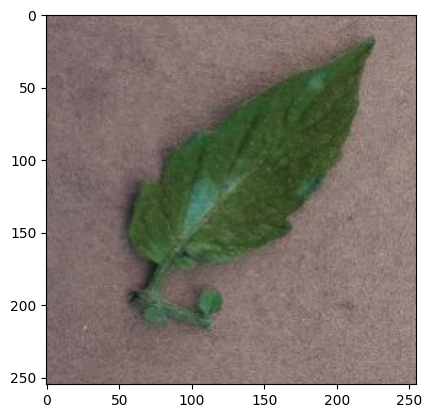

In [9]:
imgplot = plt.imshow(test_x[0])

Everything looks right. In the code above, we didn't do any preprocessing, or model building beforehand, but you could do all that before the splits, then once you have each split in the for loop, train the model, and save the results to an array, or just visually verify them. 

When you start reaching into datasets that are incredibly large (millions+), it is not uncommon to select a 99/.5/.5 or 98/1/1 split. This is because you typically have plenty of variety in data observations with such large datasets, meaning that your validation and test datasets should have a healthy variety, assuming you shuffled the data well enough. Really you just want to expose your model to a high enough variety of images in validation and testing so you know that, regardless of how complex the data is, the model will be able to pull the signal from the noise. A model trained on millions of images will forcibly be exposed to a greater variety, and thus, assuming the metrics look good, should be able to generalize more readily.

# Alternative Ways To Read In Data

Of course, images are not the only data we read in. We have all kinds of data: JSON, .csv files, .parquet files, etc. Numpy, pandas and the like all have functionality to read in data. We will also explore more complex solutions for bigger datasets that for loops and/or pandas are somewhat inefficient at doing.

## Pandas

Pandas is one of the most common choices for reading in data because of the flexibility of its DataFrame objects as well as its extended functionality in reading in more or less any data type you come across. Here we give an example of loading in .csv data using pandas and splitting it up into train, valid, test.

In [10]:
csv_location = 'data.csv'
csv_df = pd.read_csv(csv_location)
csv_df.shape

(5172, 3002)

You can see that the max observations we have here is 5172, with 3002 columns. The large number of columns is because this is a dataset of emails, where the number of incidents of each given word was counted in the email. The set was found on Kaggle: https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv. Here's a quick look at this data:

In [11]:
csv_df.head()

Email No.  the  to  ect  and  for  of    a  you  hou  ...  connevey  jay  \
0   Email 1    0   0    1    0    0   0    2    0    0  ...         0    0   
1   Email 2    8  13   24    6    6   2  102    1   27  ...         0    0   
2   Email 3    0   0    1    0    0   0    8    0    0  ...         0    0   
3   Email 4    0   5   22    0    5   1   51    2   10  ...         0    0   
4   Email 5    7   6   17    1    5   2   57    0    9  ...         0    0   

   valued  lay  infrastructure  military  allowing  ff  dry  Prediction  
0       0    0               0         0         0   0    0           0  
1       0    0               0         0         0   1    0           0  
2       0    0               0         0         0   0    0           0  
3       0    0               0         0         0   0    0           0  
4       0    0               0         0         0   1    0           0  

[5 rows x 3002 columns]

Let's make some quick code that splits up our data using only pandas.

In [12]:
def train_valid_test_split(csv_df, frac=0.1):
    
    # get random sample 
    test = csv_df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = csv_df.drop(index=test.index)

    #get random sample of valid from the rest of the training set. with frac=.1, this would be 10% * 90%=9% of the overall dataset
    valid = train.sample(frac=frac, axis=0)
    
    #get everything but the valid sample
    train = train.drop(index=valid.index)
    
    return train, valid, test

In [13]:
train, valid, test = train_valid_test_split(csv_df)

Now verify the shapes. You can add up the first value in the output yourself to see if they equal the total, 5172.

In [14]:
train.shape

(4189, 3002)

In [15]:
valid.shape

(466, 3002)

In [16]:
test.shape

(517, 3002)